## 양방향 LSTM을 이용한 개체명 인식
PyTorch의 양방향 LSTM(Bidirectional LSTM)을 이용하여 개체명 인식 모델을 구현해보겠습니다.

코퍼스로부터 각 개체(entity)의 유형을 인식하는 개체명 인식(Named Entity Recognition)에 대해서 학습합니다. 개체명 인식을 사용하면 코퍼스로부터 어떤 단어가 사람, 장소, 조직 등을 의미하는 단어인지를 찾을 수 있습니다.

###1. 개체명 인식(Name Entity Recognition)이란

개체명 인식(Named Entity Recognition)이란 말 그대로 이름을 가진 개체(named entity)를 인식하겠다는 것을 의미합니다. 좀 더 쉽게 설명하면, 어떤 이름을 의미하는 단어를 보고는 그 단어가 어떤 유형인지를 인식하는 것을 말합니다.

예를 들어 유정이는 2018년에 골드만삭스에 입사했다. 라는 문장이 있을 때, 사람(person), 조직(organization), 시간(time)에 대해 개체명 인식을 수행하는 모델이라면 다음과 같은 결과를 보여줍니다


### 2. NLTK를 이용한 개체명 인식(Namee Entity Recognition using NLTK)
NLTK에서는 개체명 인식기(NER chunker)를 지원하고 있으므로, 별도 개체명 인식기를 구현할 필요없이 NLTK를 사용해서 개체명 인식을 수행할 수 있습니다. 만약 아래의 실습에서 nltk.download('maxent_ne_chunker'), nltk.download('words') 등의 설치를 요구하는 에러 문구가 뜬다면, 지시하는대로 설치하면 됩니다.

In [2]:
import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('maxent_ne_chunker_tab')
nltk.download('words')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker_tab.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [3]:
from nltk import word_tokenize, pos_tag, ne_chunk

sentence = "James is working at Disney in London"
# 토큰화 후 품사 태깅
tokenized_sentence = pos_tag(word_tokenize(sentence))
print(tokenized_sentence)

[('James', 'NNP'), ('is', 'VBZ'), ('working', 'VBG'), ('at', 'IN'), ('Disney', 'NNP'), ('in', 'IN'), ('London', 'NNP')]


In [4]:
# 개체명 인식
ner_sentence = ne_chunk(tokenized_sentence)
print(ner_sentence)

(S
  (PERSON James/NNP)
  is/VBZ
  working/VBG
  at/IN
  (ORGANIZATION Disney/NNP)
  in/IN
  (GPE London/NNP))


ne_chunk는 개체명을 태깅하기 위해서 앞서 품사 태깅(pos_tag)이 수행되어야 합니다. 위의 결과에서 James는 PERSON(사람), Disney는 조직(ORGANIZATION), London은 위치(GPE)라고 정상적으로 개체명 인식이 수행된 것을 볼 수 있습니다. 이제 인공 신경망을 이용하여 개체명 인식 모델을 만들어보겠습니다.

###3. 양방향 LSTM을 이용한 개체명 인식


###데이터 로드 및 단어 토큰화

In [5]:
import urllib.request
import numpy as np
from tqdm import tqdm
import re
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

NLTK를 이용하면 영어 코퍼스에 토큰화와 품사 태깅 전처리를 진행한 문장 데이터를 받아올 수 있습니다. 해당 데이터를 훈련시켜 품사 태깅을 수행하는 모델을 만들어보겠습니다. 저자의 깃허브로부터 데이터를 다운로드합니다.

In [6]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/12.%20RNN%20Sequence%20Labeling/dataset/train.txt", filename="train.txt")


('train.txt', <http.client.HTTPMessage at 0x7e9cf7ee9190>)

In [7]:
f = open('train.txt', 'r')
tagged_sentences = []
sentence = []

for line in f:
    if len(line)==0 or line.startswith('-DOCSTART') or line[0]=="\n":
        if len(sentence) > 0:
            tagged_sentences.append(sentence)
            sentence = []
        continue
    splits = line.split(' ') # 공백을 기준으로 속성을 구분한다.
    splits[-1] = re.sub(r'\n', '', splits[-1]) # 줄바꿈 표시 \n을 제거한다.
    word = splits[0].lower() # 단어들은 소문자로 바꿔서 저장한다.
    sentence.append([word, splits[-1]]) # 단어와 개체명 태깅만 기록한다.

print("전체 샘플 개수: ", len(tagged_sentences)) # 전체 샘플의 개수 출력


전체 샘플 개수:  14041


In [8]:
# 첫번째 샘플만 출력
print(tagged_sentences[0])

[['eu', 'B-ORG'], ['rejects', 'O'], ['german', 'B-MISC'], ['call', 'O'], ['to', 'O'], ['boycott', 'O'], ['british', 'B-MISC'], ['lamb', 'O'], ['.', 'O']]


각 문장 샘플에 대해서 단어는 sentences에 태깅 정보는 pos_tags에 저장하고 첫번째 문장 샘플을 출력해보겠습니다.

In [9]:
sentences, ner_tags = [], []
for tagged_sentence in tagged_sentences: # 14,041개의 문장 샘플을 1개씩 가져온다
  sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에 개체명 태깅 정보들은 tag_info에 저장.
  sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장한다.
  ner_tags.append(list(tag_info)) # 각 샘플에서 개체명 태깅 정보만 저장

print(sentences[0])
print(ner_tags[0])


['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


첫번째 샘플에 대해서 단어에 대해서 sentences[0]에, 품사에 대해서만 pos_tags[0]에 저장된 것을 볼 수 있습니다. 뒤에서 보겠지만, sentences는 예측을 위한 X에 해당되며 pos_tags는 예측 대상인 y에 해당됩니다. 임의로 12번 인덱스 샘플에 대해서도 확인해보겠습니다

In [10]:
print(sentences[12])
print(ner_tags[12])

['only', 'france', 'and', 'britain', 'backed', 'fischler', "'s", 'proposal', '.']
['O', 'B-LOC', 'O', 'B-LOC', 'O', 'B-PER', 'O', 'O', 'O']


단어에 대해서만 sentences[12]에, 또한 품사에 대해서만 pos_tags[12]에 저장된 것을 확인할 수 있습니다. 또한 첫번째 샘플과 길이가 다른 것을 볼 수 있습니다. 이제 훈련 데이터와 테스트 데이터를 분리해봅시다.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(sentences, ner_tags, test_size =0.2, random_state=777)


학습이 진행되는 동안 성능을 확인하기 위한 검증 데이터 또한 분리합니다.

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=777)

학습 데이터, 검증 데이터, 테스트 데이터의 개수는 다음과 같습니다.

In [13]:
print('훈련 데이터의 개수 :', len(X_train))
print('검증 데이터의 개수 :', len(X_valid))
print('테스트 데이터의 개수 :', len(X_test))
print('훈련 데이터 레이블의 개수 :', len(X_train))
print('검증 데이터 레이블의 개수 :', len(X_valid))
print('테스트 데이터 레이블의 개수 :', len(X_test))

훈련 데이터의 개수 : 8985
검증 데이터의 개수 : 2247
테스트 데이터의 개수 : 2809
훈련 데이터 레이블의 개수 : 8985
검증 데이터 레이블의 개수 : 2247
테스트 데이터 레이블의 개수 : 2809


학습 데이터의 상위 2개 샘플만 출력해봅시다. 현재 데이터는 단어 토큰화가 된 상태입니다.

In [14]:
for sent in X_train[:2]:
  print(sent)

['young', 'boys', '9', '1', '0', '8', '6', '19', '3']
['hentgen', '(', '17-7', ')', 'surrendered', 'just', 'three', 'doubles', 'and', 'a', 'pair', 'of', 'singles', 'in', 'tossing', 'his', 'major-league', 'leading', 'ninth', 'complete', 'game', '.']


### Vocab 만들기
단어 집합을 만들어봅시다. 각 단어의 등장 빈도를 카운트해주는 Counter를 사용하여 각 단어별 빈도수를 기록합니다. 이렇게 기록된 단어의 총 종류를 출력하여 총 단어수를 확인해봅시다.

In [15]:
word_list = []
for sent in X_train:
  for word in sent:
    word_list.append(word)

word_counts = Counter(word_list)
print('총 단어수: ',len(word_counts))

총 단어수:  16742


단어수는 16,742개입니다. 임의로 영단어 the와 love의 등장횟수를 확인해보겠습니다.

In [16]:
print('훈련 데이터에서의 단어 the의 등장횟수: ', word_counts['the'])
print('훈련 데이터에서의 단어 love의 등장횟수: ', word_counts['love'])

훈련 데이터에서의 단어 the의 등장횟수:  5410
훈련 데이터에서의 단어 love의 등장횟수:  7


영단어 the의 등장 횟수는 5,410회이며, 영단어 love의 등장 횟수는 7회입니다. word_counts를 정렬하고 등장 빈도 상위 10개 단어를 출력해봅시다.

In [17]:
vocab = sorted(word_counts, key = word_counts.get , reverse = True)
print('등장 빈도수 상위 10개 단어')
print(vocab[:10])

등장 빈도수 상위 10개 단어
['the', ',', '.', 'of', 'in', 'to', 'a', ')', '(', 'and']


이제 단어 집합을 만들기 위해서 패딩을 위한 토큰, 그리고 OOV 문제(Out-Of-Vocabulary) 발생 시에 사용하는 UNK 토큰을 위한 정수 0과 1을 각각 단어 집합에 할당합니다.

In [18]:
word_to_index = {}
word_to_index['<PAD>'] = 0
word_to_index['<UNK>'] = 1

for index, word in enumerate(vocab) :
  word_to_index[word] = index + 2

vocab_size = len(word_to_index)
print('패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 :', vocab_size)


패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 : 16744


### 정수 인코딩
텍스트를 정수로 변환해주는 함수를 만듭니다. 해당 함수는 OOV 문제가 발생할 경우 해당 단어는 토큰과 맵핑되는 정수인 1로 변환합니다.

In [19]:
def texts_to_sequences(tokenized_X_data, word_to_index):
  encoded_X_data = []
  for sent in tokenized_X_data:
    index_sequences = []
    for word in sent:
      try:
        index_sequences.append(word_to_index[word])
      except KeyError:
        index_sequences.append(word_to_index['<UNK>'])
    encoded_X_data.append(index_sequences)
  return encoded_X_data

훈련 데이터, 검증 데이터, 테스트 데이터에 대해서 정수 인코딩을 진행합니다.

In [20]:
encoded_X_train = texts_to_sequences(X_train, word_to_index)
encoded_X_valid = texts_to_sequences(X_valid, word_to_index)
encoded_X_test = texts_to_sequences(X_test, word_to_index)

정수 인코딩 된 상위 샘플 2개만 출력해봅시다.

In [21]:
# 상위 샘플 2개 출력
for sent in encoded_X_train[:2]:
  print(sent)

[1260, 3215, 117, 17, 21, 123, 56, 539, 23]
[5456, 10, 8229, 9, 8230, 186, 84, 1815, 11, 8, 1073, 5, 421, 6, 8231, 35, 2043, 291, 790, 957, 267, 4]


정수로부터 단어로 변환하는 word_to_index의 key와 value를 반대로 저장하여 index_to_word를 만들고, 정수 인코딩 된 첫번째 샘플을 복원해봅시다.

In [22]:
index_to_word = {}
for key, value in word_to_index.items():
  index_to_word[value] = key

decoded_sample = [index_to_word[word] for word in encoded_X_train[0]]
print('기존의 첫번째 샘플: ', X_train[0])
print('복원된 첫번째 샘플: ', decoded_sample)

기존의 첫번째 샘플:  ['young', 'boys', '9', '1', '0', '8', '6', '19', '3']
복원된 첫번째 샘플:  ['young', 'boys', '9', '1', '0', '8', '6', '19', '3']


이제 레이블에 대해서도 정수 인코딩을 진행해야 합니다. 레이블에 존재하는 모든 단어들의 집합을 구해봅시다.

In [23]:
# y_train으로부터 존재하는 모든 태그들의 집합 구하기

flatten_tags = [tag for sent in y_train for tag in sent]
# 이 코드는 각 문장(sent) 안의 각 태그(tag)를 꺼내서 하나의 리스트로 합치는 것.

tag_vocab = list(set(flatten_tags))
print('태그 집합: ', tag_vocab)
print('태그의 집합의 크기: ', len(tag_vocab))

태그 집합:  ['I-PER', 'I-MISC', 'B-MISC', 'I-ORG', 'B-ORG', 'I-LOC', 'B-LOC', 'B-PER', 'O']
태그의 집합의 크기:  9


레이블의 각 단어에 정수를 부여하여 단어 집합(Vocabulary)를 만듭니다.

In [24]:
tag_to_index = {}
tag_to_index['<PAD>'] = 0

for index, word in enumerate(tag_vocab):
  tag_to_index[word] = index+1

tag_vocab_size = len(tag_to_index)
print('태그 집합: ', tag_to_index)

태그 집합:  {'<PAD>': 0, 'I-PER': 1, 'I-MISC': 2, 'B-MISC': 3, 'I-ORG': 4, 'B-ORG': 5, 'I-LOC': 6, 'B-LOC': 7, 'B-PER': 8, 'O': 9}


many-to-many 문제의 경우에는 레이블도 시퀀스 데이터가 되므로 각 레이블을 정수 시퀀스로 변환해줍니다. 다시 말해 레이블에 대해서 정수 인코딩을 진행합니다. 이를 위해 tag_to_index를 이용하여 레이블의 각 단어를 정수로 변환하는 함수인 encoding_label() 함수를 구현합니다.

In [25]:
def encoding_label(sequence, tag_to_index):
  label_sequence = []
  for seq in sequence:
    label_sequence.apeend([tag_to_index[tag] for tag in seq])
  return label_sequence

학습 데이터, 검증 데이터, 테스트 데이터의 레이블에 대해서 정수 인코딩을 진행합니다.

In [26]:
encoded_y_train = texts_to_sequences(y_train, tag_to_index)
encoded_y_valid = texts_to_sequences(y_valid, tag_to_index)
encoded_y_test = texts_to_sequences(y_test, tag_to_index)

In [27]:
print('X 데이터 상위 2개')
print(encoded_X_train[:2])

X 데이터 상위 2개
[[1260, 3215, 117, 17, 21, 123, 56, 539, 23], [5456, 10, 8229, 9, 8230, 186, 84, 1815, 11, 8, 1073, 5, 421, 6, 8231, 35, 2043, 291, 790, 957, 267, 4]]


### 패딩
데이터의 길이를 동일하게 맞춰주는 작업인 패딩을 위해서는 각 데이터의 길이 분포를 확인할 필요가 있습니다

샘플의 최대길이 : 78
샘플의 평균 길이 : 14.518420


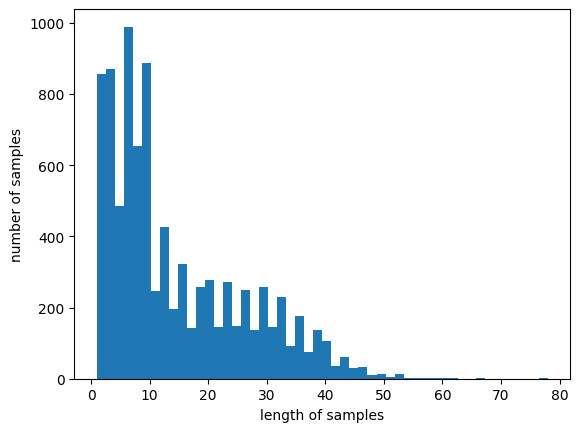

In [28]:
print("샘플의 최대길이 : %d" % max(len(l) for l in encoded_X_train))
print('샘플의 평균 길이 : %f' % (sum(map(len, encoded_X_train))/len(encoded_X_train)))

plt.hist([len(s) for s in encoded_X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

가장 긴 샘플의 길이는 78이며, 그래프를 봤을 때 전체 데이터의 길이 분포는 대체적으로 약 50내외의 길이를 가지는 것을 볼 수 있습니다. 모델이 처리할 수 있도록 encoded_X_train과 encoded_X_test의 모든 샘플의 길이를 특정 길이로 동일하게 맞춰줄 필요가 있습니다. 특정 길이 변수를 max_len으로 정합니다. 대부분의 리뷰가 내용이 잘리지 않도록 할 수 있는 최적의 max_len의 값은 몇일까요? 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수를 만듭니다.

In [29]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence)<= max_len):
      count = count +1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s' %(max_len, (count/len(nested_list))*100))

사실 최대 길이가 78이므로 78로 패딩해도 됩니다. 여기서는 80정도로 패딩해보겠습니다.

In [30]:
max_len = 80
below_threshold_len(max_len, encoded_X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 100.0


모든 데이터의 길이를 80으로 패딩해보겠습니다. max_len을 인자로 입력받아서 max_len보다 짧은 데이터의 경우에는 뒤에 0을 추가하는 함수인 pad_sequences()를 구현합니

In [31]:
def pad_sequences(sentences, max_len):
    features = np.zeros((len(sentences), max_len), dtype=int)
    for index, sentence in enumerate(sentences):
        if len(sentence) != 0:
            features[index, :len(sentence)] = np.array(sentence)[:max_len]
    return features

함수 pad_sequences()로 훈련 데이터, 검증 데이터, 테스트 데이터를 패딩합니다. 이때 개체명 인식과 같은 Many-to-Many 문제를 푸는 경우에는 레이블도 패딩해주어야 합니다. 패딩 후에 모든 데이터 길이가 80으로 패딩되었는지 확인합니다.

In [32]:
padded_X_train = pad_sequences(encoded_X_train, max_len=max_len)
padded_X_valid = pad_sequences(encoded_X_valid, max_len=max_len)
padded_X_test = pad_sequences(encoded_X_test, max_len=max_len)

padded_y_train = pad_sequences(encoded_y_train, max_len=max_len)
padded_y_valid = pad_sequences(encoded_y_valid, max_len=max_len)
padded_y_test = pad_sequences(encoded_y_test, max_len=max_len)

print('훈련 데이터의 크기 :', padded_X_train.shape)
print('검증 데이터의 크기 :', padded_X_valid.shape)
print('테스트 데이터의 크기 :', padded_X_test.shape)
print('-' * 30)
print('훈련 데이터의 레이블 :', padded_y_train.shape)
print('검증 데이터의 레이블 :', padded_y_valid.shape)
print('테스트 데이터의 레이블 :', padded_y_test.shape)


훈련 데이터의 크기 : (8985, 80)
검증 데이터의 크기 : (2247, 80)
테스트 데이터의 크기 : (2809, 80)
------------------------------
훈련 데이터의 레이블 : (8985, 80)
검증 데이터의 레이블 : (2247, 80)
테스트 데이터의 레이블 : (2809, 80)


In [33]:
# 패딩 후의 데이터를 확인해보겠습니다.
print(padded_X_train[:2])
print('-' * 5 + '레이블' + '-' * 5)
print(padded_y_train[:2])

[[1260 3215  117   17   21  123   56  539   23    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]
 [5456   10 8229    9 8230  186   84 1815   11    8 1073    5  421    6
  8231   35 2043  291  790  957  267    4    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]]
-----레이블-----
[[5 4 9 9 9 9 9 9 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0

### 모델링
이제 모델을 구현해봅시다.

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [35]:
# GPU를 사용 가능한 환경인지 확인합니다.
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("cpu와 cuda 중 다음 기기로 학습함", device)

cpu와 cuda 중 다음 기기로 학습함 cuda




이제 개체명 인식 모델을 만들어봅시다. 만약, 단방향 GRU를 모델로 사용할 경우 코드는 아래와 같습니다.

In [36]:
class NERTagger(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
    super(NERTagger,self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    # x: (batch_size, seq_length)
    embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)
    gru_out, _ = self.gru(embedded)  # (batch_size, seq_length, hidden_dim)
    logits = self.fc(gru_out)  # (batch_size, seq_length, output_dim)
    return logits


하지만 위의 GRU를 양방향 LSTM(Bidirectional LSTM) 2층짜리로 변경하려면 다음과 같이 수정하면 됩니다.

In [37]:
class NERTagger(nn.Module):
  def __init__(self,vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=2):
    super(NERTagger, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers = num_layers, batch_first=True, bidirectional=True)
    self.fc = nn.Linear(hidden_dim*2, output_dim)

  def forward(self, x):
    # x: (batch_size, seq_length)
    embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)
    lstm_out, _ = self.lstm(embedded)  # (batch_size, seq_length, hidden_dim*2)
    logits = self.fc(lstm_out)  # (batch_size, seq_length, output_dim)
    return logits

위에서 작성한 GRU 코드와 양방향 LSTM 코드의 차이점을 봅시다.

- nn.GRU를 nn.LSTM으로 변경했습니다.
- num_layers 매개변수를 추가하고 이를 nn.LSTM 생성자에 전달했습니다. 기본값은 2입니다.
- bidirectional=True를 추가하여 양방향 LSTM을 사용하도록 설정했습니다.
- nn.Linear의 입력 차원을 hidden_dim*2로 변경하여 양방향 LSTM의 출력을 처리하도록 했습니다.



In [38]:
# 사용할 데이터를 파이토치의 텐서로 변환하고, 배치 단위 처리를 위해 데이터로더로 변환합니다.
X_train_tensor = torch.tensor(padded_X_train, dtype=torch.long)
y_train_tensor = torch.tensor(padded_y_train, dtype=torch.long)
X_valid_tensor = torch.tensor(padded_X_valid, dtype=torch.long)
y_valid_tensor = torch.tensor(padded_y_valid, dtype=torch.long)
X_test_tensor = torch.tensor(padded_X_test, dtype=torch.long)
y_test_tensor = torch.tensor(padded_y_test, dtype=torch.long)

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=32)

valid_dataset = torch.utils.data.TensorDataset(X_valid_tensor, y_valid_tensor)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, shuffle=False, batch_size=32)

test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=32)


이제 위에서 선언한 NERTagger 클래스로부터 모델 객체를 만들어봅시다. 현재 단어 집합의 크기는 다음과 같습니다.

In [39]:
print('단어 집합의 크기:', vocab_size)

단어 집합의 크기: 16744


모델 객체를 선언하기 위한 하이퍼파라미터 값은 다음과 같습니다. 임베딩 벡터의 차원은 100, LSTM의 은닉 상태의 차원은 256, 출력층의 차원은 tag_vocab_size이며 앞에서 확인한 바와 같이 10이며, 학습률(learning rate)는 0.01, 학습 횟수에 해당하는 에포크는 10, LSTM의 은닉층 수는 2로 지정했습니다.

In [40]:
embedding_dim = 100
hidden_dim = 100
output_dim = tag_vocab_size
learning_rate = 0.01
num_epochs = 10
num_layers = 2

In [41]:
# 모델 객체를 선언합니다.
model = NERTagger(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers)
model.to(device)

NERTagger(
  (embedding): Embedding(16744, 100)
  (lstm): LSTM(100, 100, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=200, out_features=10, bias=True)
)

앞으로 많이 사용하게 될 비용함수인 nn.CrossEntropyLoss에서는 ignore_index를 통해서 특정 인덱스에 대한 loss를 구하지 않을 수 있습니다. ignore_index=0을 사용하면 패딩 위치에 대해서는 loss를 구하지 않습니다.

In [42]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

### 평가 코드 작성
학습하는 동안 학습 데이터와 검증 데이터에 대한 정확도와 loss를 구할 것이므로 학습하기 전에 평가 코드를 작성해야만 합니다. 우선 모델의 예측값과 실제값으로부터 정확도를 구하는 함수인 calculate_accuracy()를 작성합니다. 해당 함수에서 고려해야할 점은 패딩 토큰이 있는 부분에 대해서는 계산을 하지 않는다는 점입니다.

In [43]:
def calculate_accuracy(logits, labels, ignore_index=0):
    # 예측 레이블을 구합니다.
    predicted = torch.argmax(logits, dim=1) # torch.argmax는 텐서 안에서 가장큰 값의 인덱스를 찾아주는 함수

    # 패딩 토큰은 무시합니다.
    mask = (labels != ignore_index)

    # 정답을 맞춘 경우를 집계합니다.
    correct = (predicted == labels).masked_select(mask).sum().item()
    total = mask.sum().item()

    accuracy = correct / total
    return accuracy


검증 데이터의 데이터로더로부터 모델의 성능을 측정하는 evaluate() 함수를 구현합니다. evaluate() 함수 내부에서는 위에서 작성한 calculate_accuracy()를 호출하여 사용하고 있습니다.

In [44]:
def evaluate(model, valid_dataloader, criterion, device):
    val_loss = 0
    val_correct = 0
    val_total = 0

    model.eval()
    with torch.no_grad():
        for batch_X, batch_y in valid_dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # Forward pass
            logits = model(batch_X)

            # Compute loss
            loss = criterion(logits.view(-1, output_dim), batch_y.view(-1))

            # Calculate validation accuracy and loss
            val_loss += loss.item()
            val_correct += calculate_accuracy(logits.view(-1, output_dim), batch_y.view(-1)) * batch_y.size(0) # .view()함수는 텐서 모양 재배열, .view(-1)은 1차원으로 평탄화
            val_total += batch_y.size(0)

    val_accuracy = val_correct / val_total
    val_loss /= len(valid_dataloader)

    return val_loss, val_accuracy


### 모델 학습하기

In [45]:
# Training loop
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training
    train_loss = 0
    train_correct = 0
    train_total = 0
    model.train()
    for batch_X, batch_y in train_dataloader:
        # Forward pass
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        logits = model(batch_X)

        # Compute loss
        loss = criterion(logits.view(-1, output_dim), batch_y.view(-1))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training accuracy and loss
        train_loss += loss.item()
        train_correct += calculate_accuracy(logits.view(-1, output_dim), batch_y.view(-1)) * batch_y.size(0)
        train_total += batch_y.size(0)

    train_accuracy = train_correct / train_total
    train_loss /= len(train_dataloader)

    # Validation
    val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # 검증 손실이 최소일 때 체크포인트 저장
    if val_loss < best_val_loss:
        print(f'Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. 체크포인트를 저장합니다.')
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_checkpoint.pth')


Epoch 1/10:
Train Loss: 0.3581, Train Accuracy: 0.9036
Validation Loss: 0.2105, Validation Accuracy: 0.9392
Validation loss improved from inf to 0.2105. 체크포인트를 저장합니다.
Epoch 2/10:
Train Loss: 0.1076, Train Accuracy: 0.9685
Validation Loss: 0.1636, Validation Accuracy: 0.9525
Validation loss improved from 0.2105 to 0.1636. 체크포인트를 저장합니다.
Epoch 3/10:
Train Loss: 0.0428, Train Accuracy: 0.9873
Validation Loss: 0.1762, Validation Accuracy: 0.9505
Epoch 4/10:
Train Loss: 0.0215, Train Accuracy: 0.9936
Validation Loss: 0.2325, Validation Accuracy: 0.9390
Epoch 5/10:
Train Loss: 0.0150, Train Accuracy: 0.9955
Validation Loss: 0.2376, Validation Accuracy: 0.9435
Epoch 6/10:
Train Loss: 0.0120, Train Accuracy: 0.9963
Validation Loss: 0.2307, Validation Accuracy: 0.9504
Epoch 7/10:
Train Loss: 0.0103, Train Accuracy: 0.9968
Validation Loss: 0.2397, Validation Accuracy: 0.9495
Epoch 8/10:
Train Loss: 0.0168, Train Accuracy: 0.9946
Validation Loss: 0.2457, Validation Accuracy: 0.9457
Epoch 9/10:
Tra

학습은 정해진 횟수(num_epochs)만큼 반복되는데, 여기서는 5번 반복하도록 설정되어 있습니다. 학습 과정에서는 train_dataloader에서 배치(batch) 단위로 데이터를 가져와서 모델에 입력합니다. 모델은 입력 데이터를 처리하여 예측값(logits)을 출력하고, 이를 실제 정답(batch_y)과 비교하여 손실(loss)을 계산합니다. 그 다음, 손실을 기반으로 모델의 가중치를 조정하는 역전파(backward pass)와 최적화(optimization) 과정을 거칩니다.

각 배치마다 계산된 손실과 정확도는 에포크 단위로 누적되어 평균값으로 계산됩니다. 에포크가 끝날 때마다 학습 손실(train_loss), 학습 정확도(train_accuracy), 검증 손실(val_loss), 검증 정확도(val_accuracy)를 출력하여 모델의 성능을 모니터링합니다.

검증 손실(val_loss)이 이전에 기록된 최소 검증 손실(best_val_loss)보다 작아지면, 해당 에포크의 모델 가중치를 체크포인트(checkpoint)로 저장합니다. 이를 통해 가장 성능이 좋은 모델을 저장할 수 있습니다. 이 과정을 설정된 에포크 수만큼 반복하면서 모델을 학습시키고, 최종적으로 가장 좋은 성능을 보인 모델의 가중치를 얻게 됩니다.

### 모델 로드 및 평가
위에서 저장해둔 Best 모델을 로드하여 정상 로드되었는지 확인하기 위해서 검증 데이터에 대한 정확도와 손실을 출력하고, 테스트 데이터에 대해서도 평가를 진행합니다.

In [46]:
# 모델 로드
model.load_state_dict(torch.load('best_model_checkpoint.pth'))

# 모델을 device에 올립니다.
model.to(device)

# 검증 데이터에 대한 정확도(accuracy)와 손실(loss) 계산
val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

print(f'Best model validation loss: {val_loss:.4f}')
print(f'Best model validation accuracy: {val_accuracy:.4f}')

Best model validation loss: 0.1636
Best model validation accuracy: 0.9525


테스트 데이터에 대해서도 정확도와 손실을 계산합니다.


In [47]:
# 테스트 데이터에 대한 정확도와 손실 계산
test_loss, test_accuracy = evaluate(model, test_dataloader, criterion, device)

print(f'Best test loss: {test_loss:.4f}')
print(f'Best test accuracy: {test_accuracy:.4f}')

Best test loss: 0.1601
Best test accuracy: 0.9530


### 인퍼런스 및 테스트
모델을 서비스에 적용하게 되면 전처리가 전혀 되어있지 않은 임의의 텍스트 입력에 대해서 동작해야 할 것입니다. 임의의 텍스트 입력에 대해서 예측 레이블을 리턴하는 함수를 만들어봅시다.

In [48]:
index_to_tag = {}
for key, value in tag_to_index.items():
  index_to_tag[value] = key

def predict_labels(text, model, word_to_ix, index_to_tag, max_len=150):
  # 단어 토큰화
  tokens = text.split()

  # 정수 인코딩
  token_indices = [word_to_ix.get(token, 1) for token in tokens]

  # 패딩
  token_indices_padded = np.zeros(max_len, dtype=int)
  token_indices_padded[:len(token_indices)] = token_indices[:max_len]

  # 텐서로 변환
  input_tensor = torch.tensor(token_indices_padded, dtype=torch.long).unsqueeze(0).to(device)

  # 모델의 입력으로 사용하고 예측값 리턴
  model.eval()
  with torch.no_grad():
    logits = model(input_tensor)

  # 가장 값이 높은 인덱스를 예측값으로 선택
  predicted_indices = torch.argmax(logits, dim=-1).squeeze(0).tolist()

  # 패딩 토큰 제거
  predicted_indices_no_pad = predicted_indices[:len(tokens)]

  # 패딩 토큰을 제외하고 정수 시퀀스를 예측 시퀀스로 변환
  predicted_tags = [index_to_tag[index] for index in predicted_indices_no_pad]

  return predicted_tags

학습에 사용되지 않은 테스트 데이터의 첫번째 샘플을 이용해봅시다. 현재 이 데이터는 이미 단어 토큰화가 된 상태라서 단어 토큰화 이전 상태로 되돌려 전처리가 전혀 되어있지 않은 입력을 가정하고 함수에 입력으로 사용하겠습니다.

In [49]:
print(X_test[0])

['feyenoord', 'rotterdam', 'suffered', 'an', 'early', 'shock', 'when', 'they', 'went', '1-0', 'down', 'after', 'four', 'minutes', 'against', 'de', 'graafschap', 'doetinchem', '.']


토큰화 이전 상태로 돌린 후는 다음과 같습니다.

In [50]:
sample = ' '.join(X_test[0])
print(sample)

feyenoord rotterdam suffered an early shock when they went 1-0 down after four minutes against de graafschap doetinchem .


실제 레이블과 예측값을 비교해봅시다.

In [51]:
predicted_tags = predict_labels(sample, model, word_to_index, index_to_tag)
print('예측 : ', predicted_tags)
print('실제값 : ', y_test[0])

예측 :  ['B-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'I-LOC', 'I-LOC', 'O']
실제값 :  ['B-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'O']
